#Importing Kaggle DateSets

In [ ]:
# Install Kaggle
! pip install kaggle

In [ ]:
# Mount Google Drive.
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
# Kaggle JSON File Path
! cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/

In [ ]:
# Change peermissions so only you can access the Kaggle Files
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download Kaggle DataSets
! kaggle datasets download -d barelydedicated/savee-database
! kaggle datasets download -d ejlok1/cremad
! kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio

savee-database.zip: Skipping, found more recently modified local copy (use --force to force download)
cremad.zip: Skipping, found more recently modified local copy (use --force to force download)
ravdess-emotional-speech-audio.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# Unzip the Zipped DataSets
! mkdir kaggle_data
! unzip {"savee-database"+ ".zip"} -d kaggle_data/Savee
! unzip {"cremad"+ ".zip"} -d kaggle_data/Cremad
! unzip {"ravdess-emotional-speech-audio" + ".zip"} -d kaggle_data/Ravdess

Archive:  cremad.zip
  inflating: kaggle_data/Cremad/AudioWAV/1001_DFA_ANG_XX.wav  
  inflating: kaggle_data/Cremad/AudioWAV/1001_DFA_DIS_XX.wav  
  inflating: kaggle_data/Cremad/AudioWAV/1001_DFA_FEA_XX.wav  
  inflating: kaggle_data/Cremad/AudioWAV/1001_DFA_HAP_XX.wav  
  inflating: kaggle_data/Cremad/AudioWAV/1001_DFA_NEU_XX.wav  
  inflating: kaggle_data/Cremad/AudioWAV/1001_DFA_SAD_XX.wav  
  inflating: kaggle_data/Cremad/AudioWAV/1001_IEO_ANG_HI.wav  
  inflating: kaggle_data/Cremad/AudioWAV/1001_IEO_ANG_LO.wav  
  inflating: kaggle_data/Cremad/AudioWAV/1001_IEO_ANG_MD.wav  
  inflating: kaggle_data/Cremad/AudioWAV/1001_IEO_DIS_HI.wav  
  inflating: kaggle_data/Cremad/AudioWAV/1001_IEO_DIS_LO.wav  
  inflating: kaggle_data/Cremad/AudioWAV/1001_IEO_DIS_MD.wav  
  inflating: kaggle_data/Cremad/AudioWAV/1001_IEO_FEA_HI.wav  
  inflating: kaggle_data/Cremad/AudioWAV/1001_IEO_FEA_LO.wav  
  inflating: kaggle_data/Cremad/AudioWAV/1001_IEO_FEA_MD.wav  
  inflating: kaggle_data/Cremad/Au

#Importing Required Libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

import librosa
import librosa.display
from IPython.display import Audio
import warnings

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

warnings.filterwarnings("ignore")

#Checking the DataSets

In [ ]:
# Define paths as variables for easy-access
Cremad = "/content/kaggle_data/Crema/AudioWAV"
Ravdess = "/content/kaggle_data/Ravdess/audio_speech_actors_01-24"
Savee = "/content/kaggle_data/Savee/audiodata/AudioData"

In [ ]:
# Ravdess DataSet
ravdess_directory_list = os.listdir(Ravdess)
file_emotion = []

file_path = []
for i in ravdess_directory_list:
    actor = os.listdir(Ravdess +"/"+ i)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file is emotion
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess+"/" + i + '/' + file)

# list to dataframe
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])

# Combining
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# int to emotion
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgusted', 8:'surprised'}, inplace=True)
Ravdess_df.head()

Emotions                                               Path
0    neutral  /content/kaggle_data/Ravdess/audio_speech_acto...
1        sad  /content/kaggle_data/Ravdess/audio_speech_acto...
2      angry  /content/kaggle_data/Ravdess/audio_speech_acto...
3        sad  /content/kaggle_data/Ravdess/audio_speech_acto...
4  disgusted  /content/kaggle_data/Ravdess/audio_speech_acto...

In [ ]:
Ravdess_df["Emotions"].value_counts()

sad          192
angry        192
disgusted    192
surprised    192
calm         192
happy        192
fear         192
neutral       96
Name: Emotions, dtype: int64

In [ ]:
# Crema-D DataSet
crema_dir = os.listdir(Cremad)

file_emotion = []
file_path = []

for file in crema_dir:
    # storing file paths
    file_path.append(Cremad+"/" + file)
    # storing file emotions
    part=file.split('_')[0]
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)


Crema_df.head()

Emotions                                               Path
0  Unknown  /content/kaggle_data/Crema/AudioWAV/1050_IWW_D...
1  Unknown  /content/kaggle_data/Crema/AudioWAV/1073_TAI_D...
2  Unknown  /content/kaggle_data/Crema/AudioWAV/1005_ITS_F...
3  Unknown  /content/kaggle_data/Crema/AudioWAV/1052_IWL_F...
4  Unknown  /content/kaggle_data/Crema/AudioWAV/1010_IEO_N...

In [ ]:
Crema_df["Emotions"].value_counts()

Unknown    1
Name: Emotions, dtype: int64

In [ ]:
# Savee DataSet
directory_list = next(os.walk(Savee))[1]
file_emotion = []

file_path = []
for i in directory_list:
    actor = os.listdir(Savee +"/"+ i)
    for file in actor:
        file_emotion.append(file[:-6])
        file_path.append(Savee+"/" + i + '/' + file)

# list to dataframe
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])

# Combining
Savee_df = pd.concat([emotion_df, path_df], axis=1)

# letter to full emotion
Savee_df.Emotions.replace({'a':'angry', 'd':'disgusted', 'f':'fear', 'h':'happy', 'n':'neutral', 'sa':'sad' , 'su':'surprised'}, inplace=True)
Savee_df.head()

Emotions                                               Path
0  disgusted  /content/kaggle_data/Savee/audiodata/AudioData...
1  disgusted  /content/kaggle_data/Savee/audiodata/AudioData...
2    neutral  /content/kaggle_data/Savee/audiodata/AudioData...
3  disgusted  /content/kaggle_data/Savee/audiodata/AudioData...
4    neutral  /content/kaggle_data/Savee/audiodata/AudioData...

#Combining DataSets into One

In [ ]:
df = pd.concat([Ravdess_df, Crema_df, Savee_df], axis = 0)
df.to_csv("data.csv",index=False)
df.head()

Emotions                                               Path
0    neutral  /content/kaggle_data/Ravdess/audio_speech_acto...
1        sad  /content/kaggle_data/Ravdess/audio_speech_acto...
2      angry  /content/kaggle_data/Ravdess/audio_speech_acto...
3        sad  /content/kaggle_data/Ravdess/audio_speech_acto...
4  disgusted  /content/kaggle_data/Ravdess/audio_speech_acto...

In [ ]:
df.reset_index(drop=True,inplace=True)

In [ ]:
df["Emotions"].value_counts()

sad          252
angry        252
disgusted    252
surprised    252
happy        252
fear         252
neutral      216
calm         192
Name: Emotions, dtype: int64

# Data Visualization

In [ ]:
import matplotlib.pyplot as plt
plt.xticks( rotation='vertical')
sns.countplot(df["Emotions"])

In [ ]:
def waveplot(data,sr,emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion,size=20)
    librosa.display.waveshow(data,sr=sr)
    plt.show()

def spectogram(data,sr,emotion):
    x=librosa.stft(data)
    xdb=librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion,size=20)
    librosa.display.specshow(xdb,sr=sr,x_axis="time",y_axis="hz")
    plt.colorbar()

In [ ]:
emot=["disgusted","fear","sad","happy","angry","neutral","surprised","calm"]

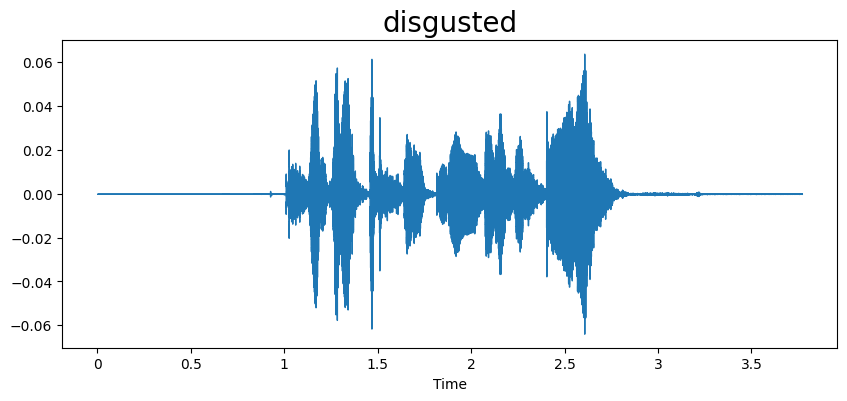

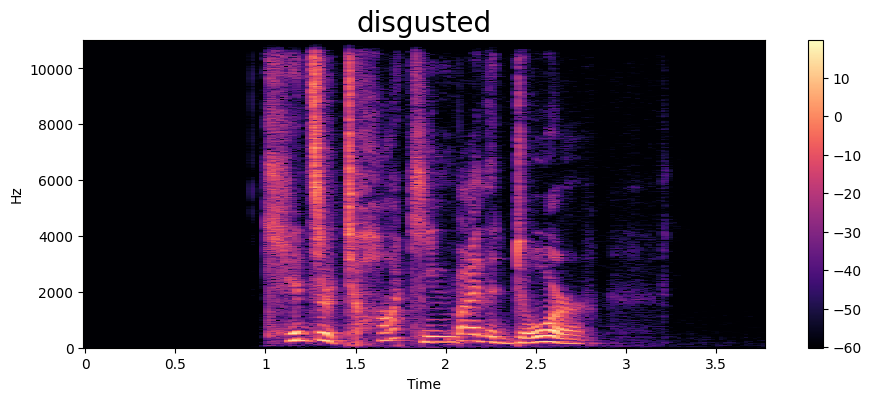

In [ ]:
# Emotion Index= 0 - Disgust
emotion=emot[0]
path=np.array(df["Path"][df["Emotions"]==emotion])[0]
data,sampling_rate=librosa.load(path)

waveplot(data,sampling_rate,emotion)
spectogram(data,sampling_rate,emotion)
Audio(path)

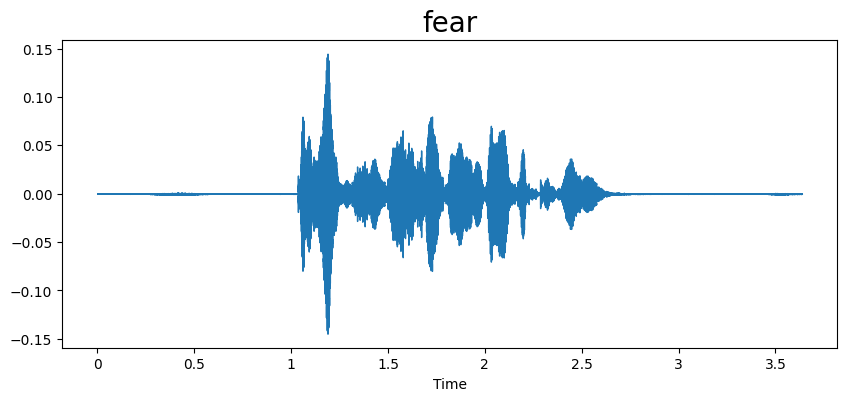

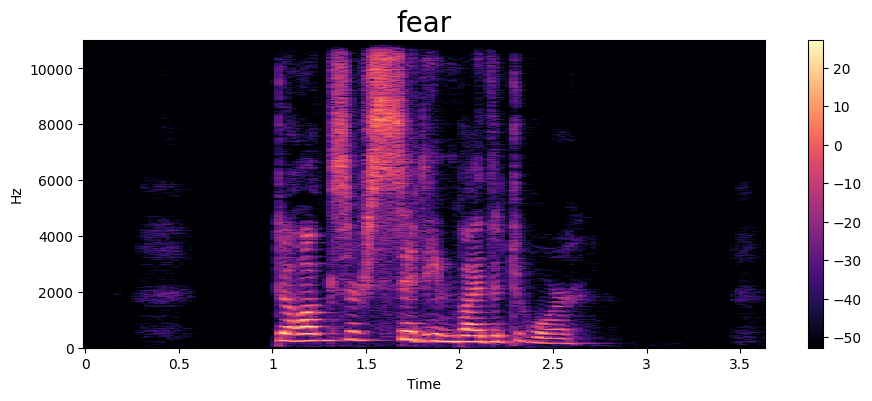

In [ ]:
# Emotion Index= 1 - Fear
emotion=emot[1]
path=np.array(df["Path"][df["Emotions"]==emotion])[0]
data,sampling_rate=librosa.load(path)

waveplot(data,sampling_rate,emotion)
spectogram(data,sampling_rate,emotion)
Audio(path)

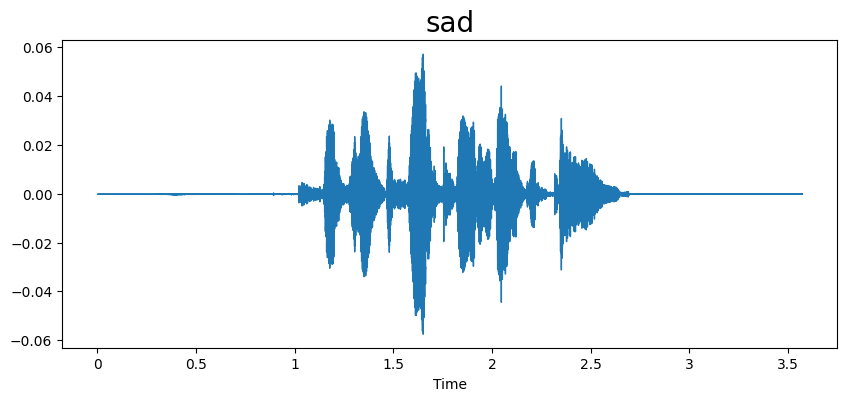

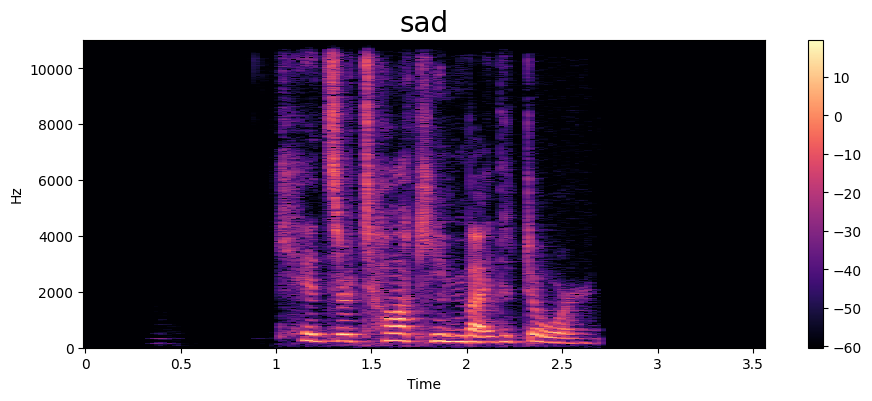

In [ ]:
# Emotion Index= 2 - Sadness
emotion=emot[2]
path=np.array(df["Path"][df["Emotions"]==emotion])[0]
data,sampling_rate=librosa.load(path)

waveplot(data,sampling_rate,emotion)
spectogram(data,sampling_rate,emotion)
Audio(path)

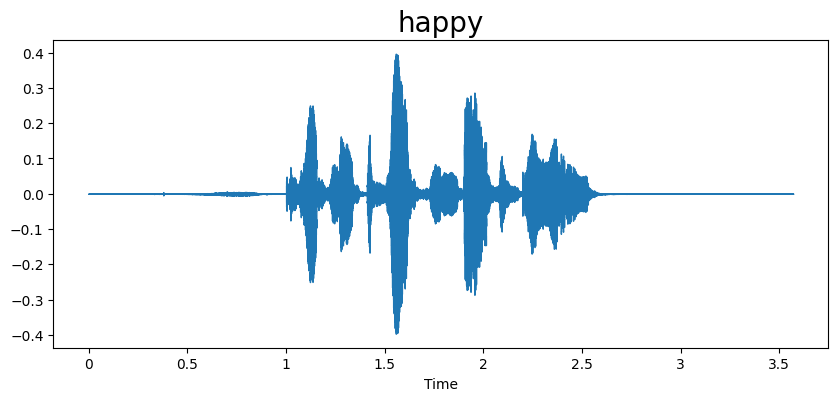

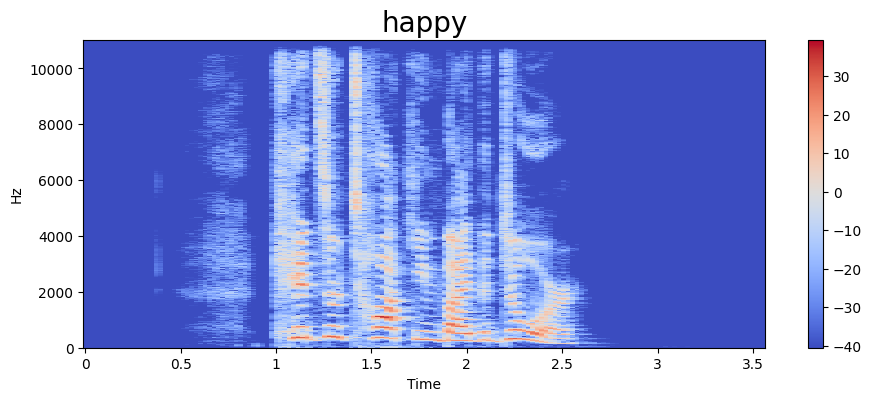

In [ ]:
# Emotion Index= 3 - Happiness
emotion=emot[3]
path=np.array(df["Path"][df["Emotions"]==emotion])[0]
data,sampling_rate=librosa.load(path)

waveplot(data,sampling_rate,emotion)
spectogram(data,sampling_rate,emotion)
Audio(path)

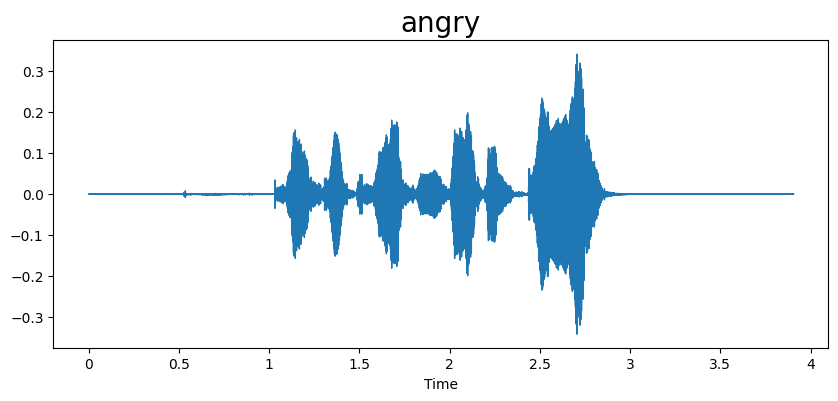

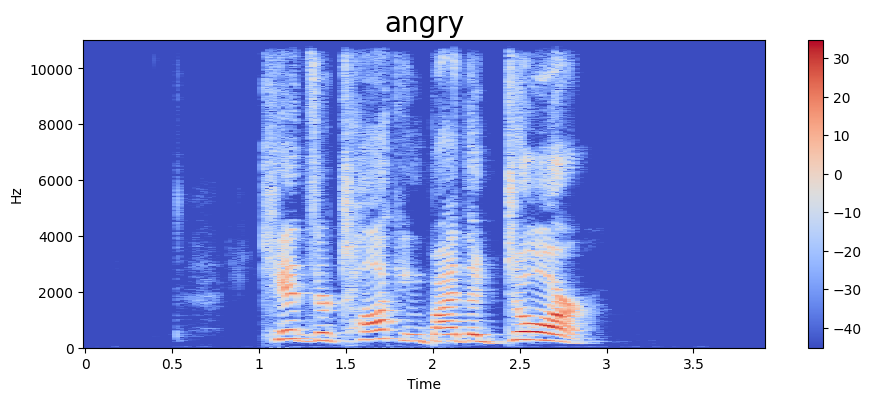

In [ ]:
# Emotion Index= 4 - Anger
emotion=emot[4]
path=np.array(df["Path"][df["Emotions"]==emotion])[100]
data,sampling_rate=librosa.load(path)
waveplot(data,sampling_rate,emotion)
spectogram(data,sampling_rate,emotion)
Audio(path)

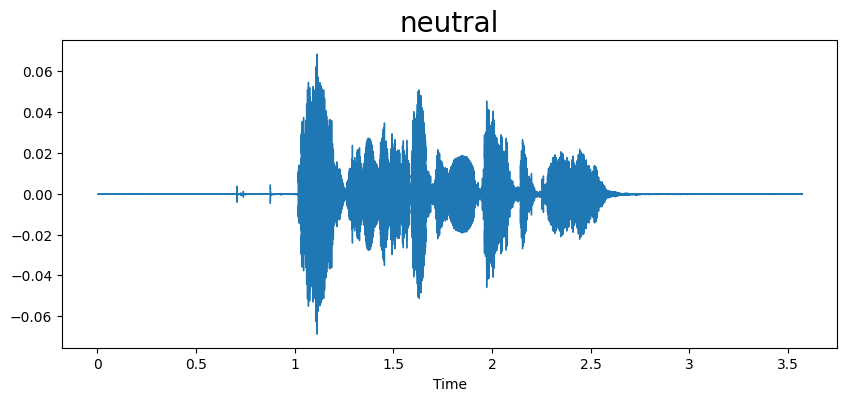

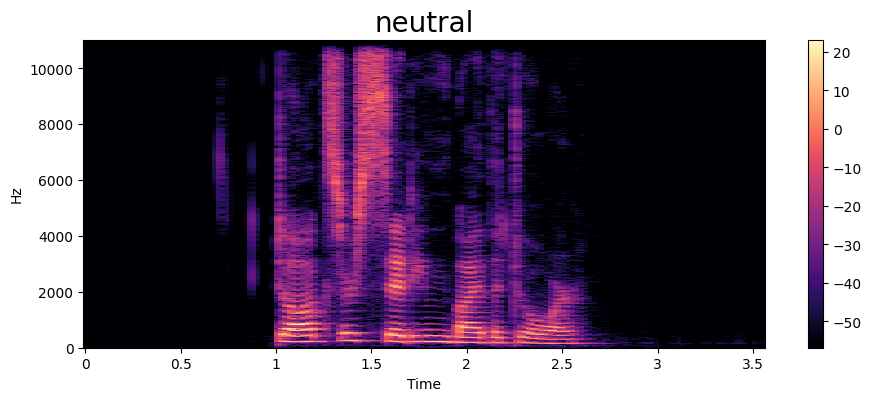

In [ ]:
# Emotion Index= 5 - Neutral
emotion=emot[5]
path=np.array(df["Path"][df["Emotions"]==emotion])[0]
data,sampling_rate=librosa.load(path)

waveplot(data,sampling_rate,emotion)
spectogram(data,sampling_rate,emotion)
Audio(path)

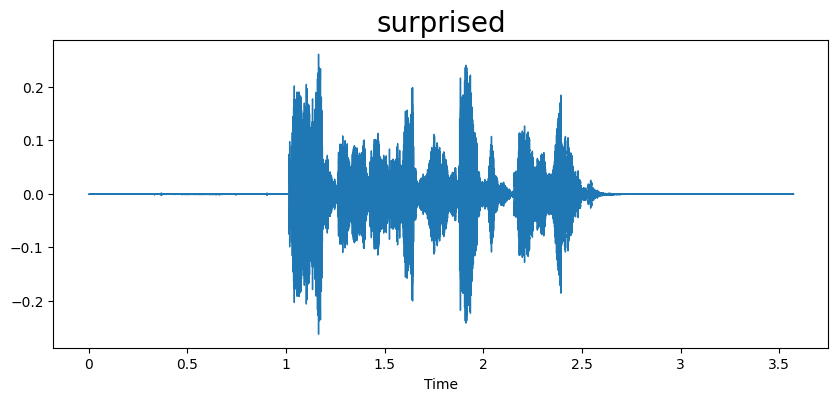

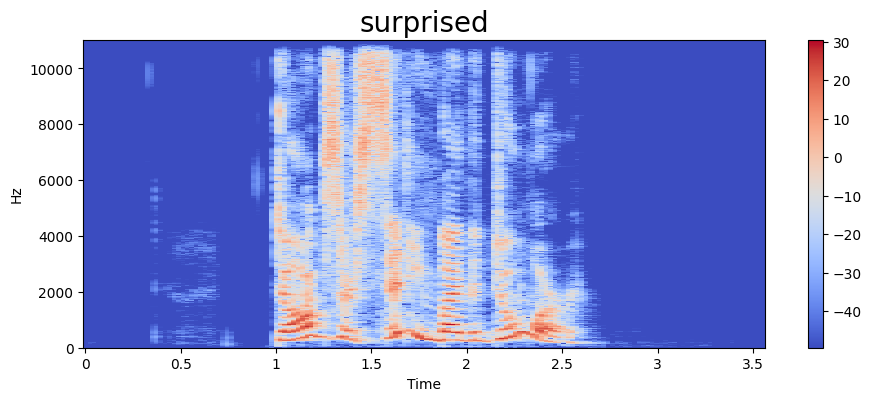

In [ ]:
# Emotion Index= 6 - Surprise
emotion=emot[6]
path=np.array(df["Path"][df["Emotions"]==emotion])[0]
data,sampling_rate=librosa.load(path)

waveplot(data,sampling_rate,emotion)
spectogram(data,sampling_rate,emotion)
Audio(path)

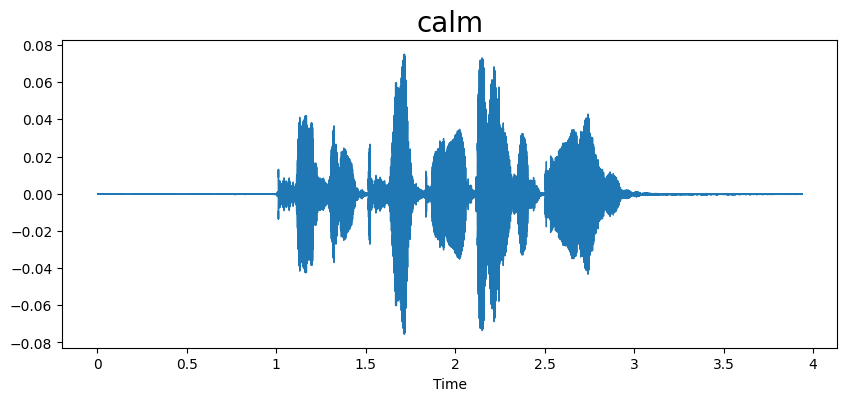

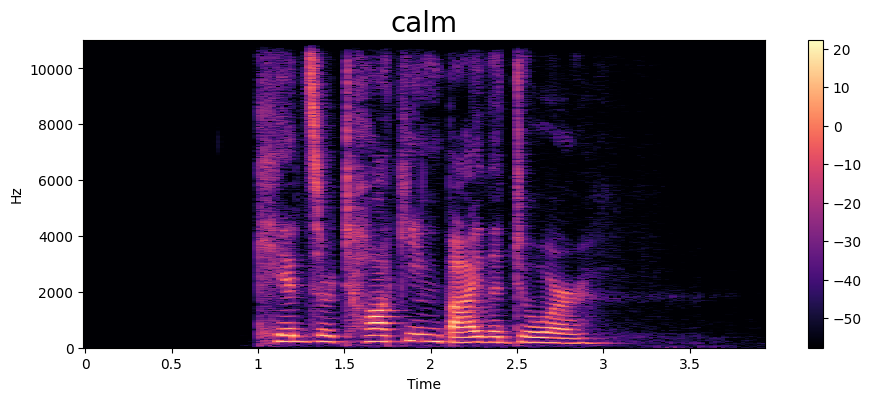

In [ ]:
# Emotion Index= 7 - Calmness
emotion=emot[7]
path=np.array(df["Path"][df["Emotions"]==emotion])[0]
data,sampling_rate=librosa.load(path)

waveplot(data,sampling_rate,emotion)
spectogram(data,sampling_rate,emotion)
Audio(path)

#Creating WaveShow from the Samples

In [ ]:
def noise(data):
    noise_amp = 0.030*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.75):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(df.Path)[1]
data, sample_rate = librosa.load(path)

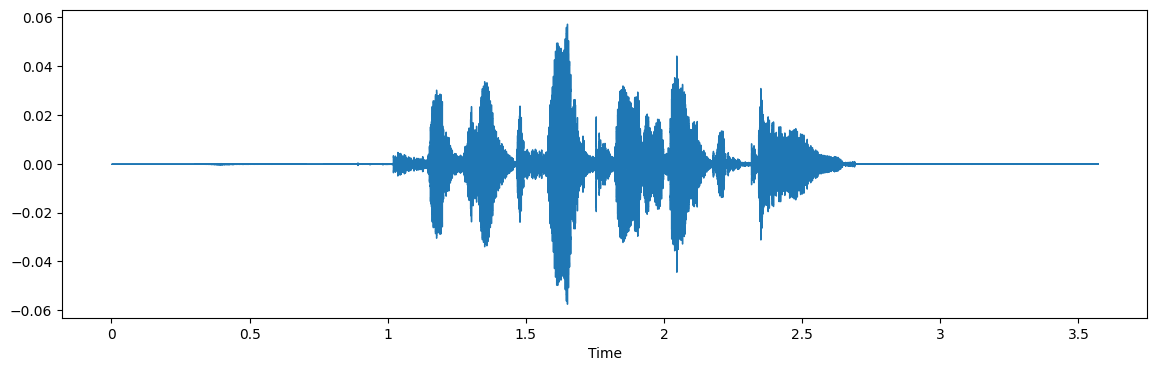

In [ ]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

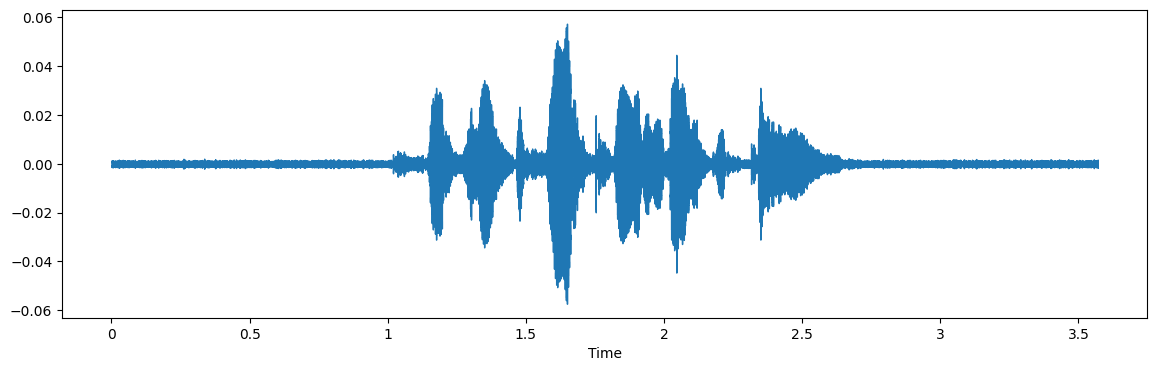

In [ ]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

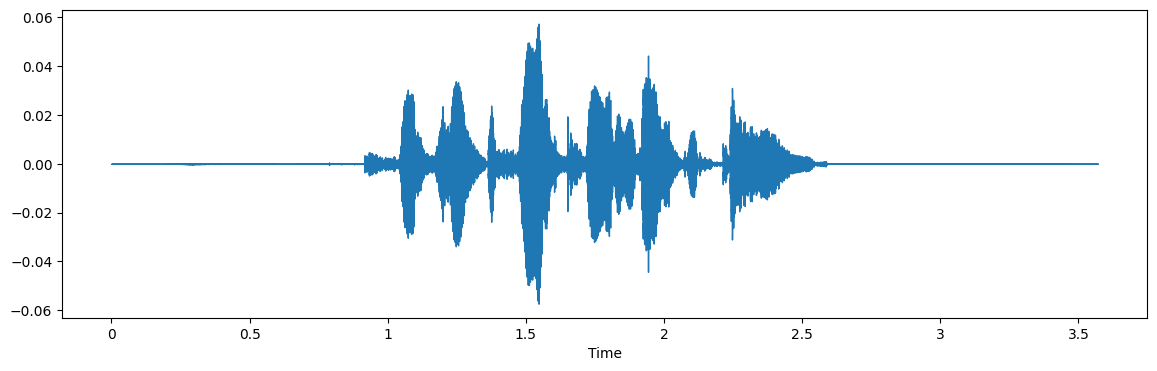

In [ ]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)